# Band Ratios Conflations

This notebook steps through how  band ratio measures are underdetermined. 

By 'underdetermined', we mean that the same value, or same change in value between measures, can arise from different underlying causes. 

This shows that band ratios are a non-specific measure.

As an example case, we use the theta-beta ratio.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from fooof import FOOOF
from fooof.sim import gen_power_spectrum
from fooof.plts.spectra import (plot_spectrum, plot_spectra,
                                plot_spectrum_shading, plot_spectra_shading)

In [2]:
# Import custom project code
import sys
sys.path.append('../bratios')
from ratios import calc_band_ratio
from paths import FIGS_PATHS as fp

In [3]:
# Settings
SAVE_FIG = False
PLOT_TITLES = True    # Whether to plot titles on each axis

In [4]:
# Plot settings
shade_color = '#0365C0'

In [5]:
# Band Settings
theta_band = [4, 8]
beta_band = [20, 30]

# Set up index helpers
cf_ind = 0
pw_ind = 1
bw_ind = 2

In [6]:
# Simulated power spectra settings
freq_range = [1, 35]
freq_res = 0.1
nlv = 0

# Define default aperiodic values
ap_def = [0, 1]

# Define default periodic values
theta_def = [6, 0.4, 1]
alpha_def = [10, 0.5, 0.75]
beta_def  = [25, 0.3, 1.5]

## Comparing Band Ratio Values

First, let's consider a hypothetical investigation comparing band ratio measures between two groups.

The typical interpretation of finding a difference between measured band ratios would be that there is a difference in the relative powers of the oscillation bands used in the calculation of the band ratio. That is to say, the change in ratio could come from a change in two things (the power of the low band, and/or the power of the high band). 

Here, we will show that there are actually many more ways in which one could measure this difference.

A numerically identically change in theta / beta ratio can be obtained from:

#### Periodic Changes
- a change in theta power
- a change in theta bandwidth
- a change in beta center frequency
- a change in beta power
- a change in beta bandwidth

#### Aperiodic Changes
- a change in aperiodic exponent
    - with or without oscillations present
    
Note that the specific values in the simulations below have been tuned to create numerically identical changes in measured band ratio.

In [7]:
# Create a baseline PSD, with oscillations, to compare to
freqs, ps_base = gen_power_spectrum(freq_range, ap_def,
                                    [theta_def, alpha_def, beta_def],
                                    nlv, freq_res)

### Periodic Changes

In [8]:
## CF
# Change in center frequency - high band
beta_cf = beta_def.copy(); beta_cf[cf_ind] = 19.388
freqs, ps_be_cf = gen_power_spectrum(freq_range, ap_def,
                                     [theta_def, alpha_def, beta_cf],
                                     nlv, freq_res)

## PW
# Changes in oscillation power - low band
theta_pw = theta_def.copy(); theta_pw[pw_ind] = 0.5041
freqs, ps_th_pw = gen_power_spectrum(freq_range, ap_def,
                                     [theta_pw, alpha_def, beta_def],
                                     nlv, freq_res)
# Changes in oscillation power - high band
beta_pw = beta_def.copy(); beta_pw[pw_ind] = 0.1403
freqs, ps_be_pw = gen_power_spectrum(freq_range, ap_def,
                                     [theta_def, alpha_def, beta_pw],
                                     nlv, freq_res)

## BW
# Changes in oscillation bandwidth - low band
theta_bw = theta_def.copy(); theta_bw[bw_ind] = 1.61
freqs, ps_th_bw = gen_power_spectrum(freq_range, ap_def,
                                     [theta_bw, alpha_def, beta_def],
                                     nlv, freq_res)
# Changes in oscillation bandwidth - high band
beta_bw = beta_def.copy(); beta_bw[bw_ind] = 0.609
freqs, ps_be_bw = gen_power_spectrum(freq_range, ap_def,
                                     [theta_def, alpha_def, beta_bw],
                                     nlv, freq_res)

In [9]:
# Changes in other band - center frequency
alpha_cf = alpha_def.copy(); alpha_cf[cf_ind] = 8.212
freqs, ps_al_cf = gen_power_spectrum(freq_range, ap_def,
                                     [theta_def, alpha_cf, beta_def],
                                     nlv, freq_res)

# Changes in other band - bandwidth
alpha_bw = alpha_def.copy(); alpha_bw[bw_ind] = 1.8845
freqs, ps_al_bw = gen_power_spectrum(freq_range, ap_def,
                                     [theta_def, alpha_bw, beta_def],
                                     nlv, freq_res)

In [10]:
# Collect all the power spectra together
spectra_data = {'Theta Frequency' : None,
                'Theta Power' : ps_th_pw,
                'Theta Bandwidth' : ps_th_bw,
                'Alpha Frequency' : ps_al_cf,
                'Alpha Power' : None,
                'Alpha Bandwidth' : ps_al_bw,
                'Beta Frequency' : ps_be_cf,
                'Beta Power' : ps_be_pw,
                'Beta Bandwidth' : ps_be_bw}

In [11]:
# Calcualte theta beta ratio of the baseline power spectrum
base_br = calc_band_ratio(freqs, ps_base, theta_band, beta_band)

In [12]:
# Calculate changes in theta / beta ratios
diffreqs = {}
for label, spectra in spectra_data.items():
    if np.all(spectra):
        comp_br = calc_band_ratio(freqs, spectra, theta_band, beta_band)
        diffreqs[label] = base_br - comp_br

In [13]:
# Check the computed ratio values of each spectrum
print('TBR of base spectrum is: {:1.3f}'.format(base_br))
print('TBR of comp spectrum is: {:1.3f}'.format(comp_br))

TBR of base spectrum is: 5.737
TBR of comp spectrum is: 6.737


In [14]:
# Check TBR difference measures from periodic changes
for label, diff in diffreqs.items():
    print('TBR difference from   {:20}   is \t {:1.3f}'.format(label, diff))

TBR difference from   Theta Power            is 	 -1.000
TBR difference from   Theta Bandwidth        is 	 -1.000
TBR difference from   Alpha Frequency        is 	 -1.000
TBR difference from   Alpha Bandwidth        is 	 -1.000
TBR difference from   Beta Frequency         is 	 -1.000
TBR difference from   Beta Power             is 	 -1.000
TBR difference from   Beta Bandwidth         is 	 -1.000


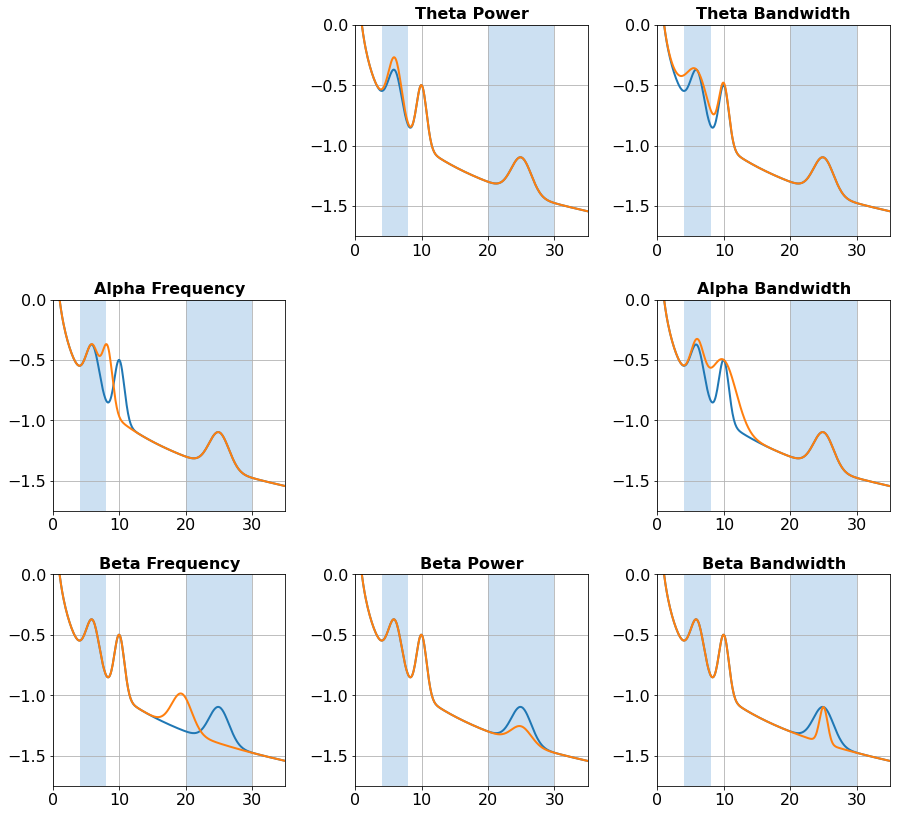

In [15]:
# Create figure of periodic changes
title_settings = {'fontsize': 16, 'fontweight': 'bold'}
fig, ax = plt.subplots(3, 3, figsize=(15, 14))

for axis, (title, data) in zip(ax.flatten(), spectra_data.items()):
    
    if not np.all(data): continue
    
    plot_spectra_shading(freqs, [ps_base, data], [theta_band, beta_band],
                         shade_colors=shade_color,
                         log_freqs=False, log_powers=True, ax=axis)
    
    if PLOT_TITLES:
        axis.set_title(title, **title_settings)
    
    axis.set_xlim([0, 35])
    axis.set_ylim([-1.75, 0])

    axis.xaxis.label.set_visible(False)
    axis.yaxis.label.set_visible(False)
    
# Turn off empty axes
ax[0, 0].axis('off')
ax[1, 1].axis('off')
    
fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.3)

if SAVE_FIG: plt.savefig(fp.make_file_path(fp.demo, 'Underdetermined-Periodic', 'pdf'))

Each panel above plots two PSDs, where the blue curve is the same reference power spectrum plotted in all panels, and the orange is a unique comparison spectrum. 

The difference between TBR from the blue and orange curve is the same (see cell above) across each panel. 

This shows that multiple spectral parameters could change to arrive at identical differences in a ratio measure.

#### Periodic Notes

Note that for a given change (or direction of change) in theta / beta ratio (TBR), there is only one center frequency change that could do it. 

This is true for the case, as is simulated, in which the 'baseline' spectrum has oscillations entirely within band ranges. In this example, the change is a relative increase in 'theta', and there is no way to increase relative theta by changing theta CF alone. This is due to the choice of comparison spectrum, and in another scenario, theta CF could also change measured ratio measures.

### Aperiodic Changes

The same change in ratio can also be driven from changes in aperiodic properties. 

This can happen with or without oscillations even being present.

In [16]:
# Change in aperiodic exponent
ap_shift = [0.13, 1.1099]
freqs, ps_ap_ex = gen_power_spectrum(freq_range, ap_shift,
                                     [theta_def, alpha_def, beta_def],
                                     nlv, freq_res)

In [17]:
# Use a new base and transformation, without any oscillations
freqs, ps_new_base = gen_power_spectrum(freq_range, ap_def, [],
                                        nlv, freq_res)
ap_shift = [0.13, 1.1417]
freqs, ps_new_apch = gen_power_spectrum(freq_range, ap_shift, [],
                                        nlv, freq_res)

In [18]:
# Calculate the differences in ratio from baseline spectra
d_ap_osc = base_br - calc_band_ratio(freqs, ps_ap_ex, theta_band, beta_band)
d_ap_no_osc = calc_band_ratio(freqs, ps_new_base, theta_band, beta_band) - \
              calc_band_ratio(freqs, ps_new_apch, theta_band, beta_band)

In [19]:
# Check TBR difference measures from aperiodic changes
base_text = 'TBR difference from the aperiodic component '
print(base_text + 'with oscillations      is \t {:1.3f}'.format(d_ap_osc))
print(base_text + 'without oscillations   is \t {:1.3f}'.format(d_ap_no_osc))

TBR difference from the aperiodic component with oscillations      is 	 -1.000
TBR difference from the aperiodic component without oscillations   is 	 -1.000


In [20]:
# Collect together components to plot
ap_bases = [ps_base, ps_new_base]
ap_diffs = [ps_ap_ex, ps_new_apch]

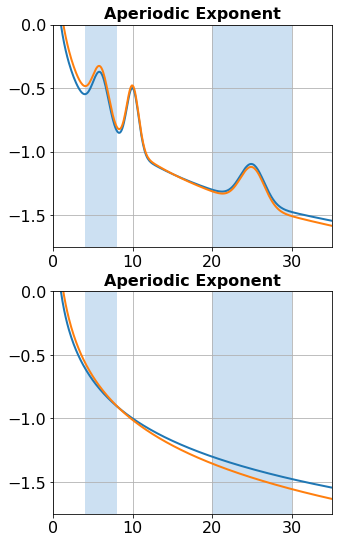

In [21]:
# Create aperiodic differences figure
fig, ax = plt.subplots(2, 1, figsize=(5, 9))

for ps_base, ps_diff, axis in zip(ap_bases, ap_diffs, ax.flatten()):
    
    plot_spectra_shading(freqs, [ps_base, ps_diff], [theta_band, beta_band],
                         shade_colors=shade_color,
                         log_freqs=False, log_powers=True, ax=axis)
    
    if PLOT_TITLES:
        axis.set_title('Aperiodic Exponent', **title_settings)
    
    # Plot Aesthetics
    axis.set_xlim([0, 35])
    axis.set_ylim([-1.75, 0])
    axis.xaxis.label.set_visible(False)
    axis.yaxis.label.set_visible(False)
    
fig.subplots_adjust(wspace=.3)

if SAVE_FIG: plt.savefig(fp.make_file_path(fp.demo, 'Underdetermined-Aperiodic', 'pdf'))

#### Conclusions

In this example, we have explored changes to measured band ratios by varying different spectral parameters.

Given an observed change in a BandRatio measure, there is no way to tell what has actually changed.

Variations in multiple spectral parameters can lead to the exact same change in ratio measure.

There is no reason to think the change even reflects oscillatory activity, given that aperiodic shifts can drive this effect. 

In this notebook, we simulated variations in one parameter at a time, but in practice, all of these changes could happen together. 

In subsequent notebooks, we will further characterize these findings by simulating changes in each parameter, to estimate how impactful different parameters are to ratio measures, as well as by simulating concurrent changes in multiple parameters, to explore the interaction between changes.

## Same Ratio, Different Spectra

So far we have seen how multiple possible changes in power spectra can lead to the same measured difference in band ratio measures across power spectra.

What if we calculate band ratio measures and find that they are the same? Can we infer that the analyzed power spectra are in some ways equivalent? 

Next, let's examine if and how different power spectra can have the same band ratio value. 

In [22]:
# Create a collection of spectra with different properties, with the same measured ratio value
freqs, ps1 = gen_power_spectrum(freq_range, [0, 0.9059],
                                [theta_def, alpha_def, beta_def],
                                nlv, freq_res)
freqs, ps2 = gen_power_spectrum(freq_range, [0, 0.9059],
                                [[6, 0.5, 2], alpha_def, [25, 0.3544, 5]],
                                nlv, freq_res)
freqs, ps3 = gen_power_spectrum(freq_range, [0.25, 1.2029],
                                [[6, 0.10, 1], alpha_def, beta_def],
                                nlv, freq_res)
freqs, ps4 = gen_power_spectrum(freq_range, [0.25, 1.2029],
                                [theta_def, alpha_def, [25, 0.66444, 1.5]],
                                nlv, freq_res)

In [23]:
# Collect the generated spectra together
spectra_list = [ps1, ps2, ps3, ps4]

In [24]:
# Calculate the ratio value for each spectrum
for spectrum in spectra_list:
    print('Ratio value:\t {:1.3f}'.format(calc_band_ratio(freqs, ps1, theta_band, beta_band)))

Ratio value:	 5.000
Ratio value:	 5.000
Ratio value:	 5.000
Ratio value:	 5.000


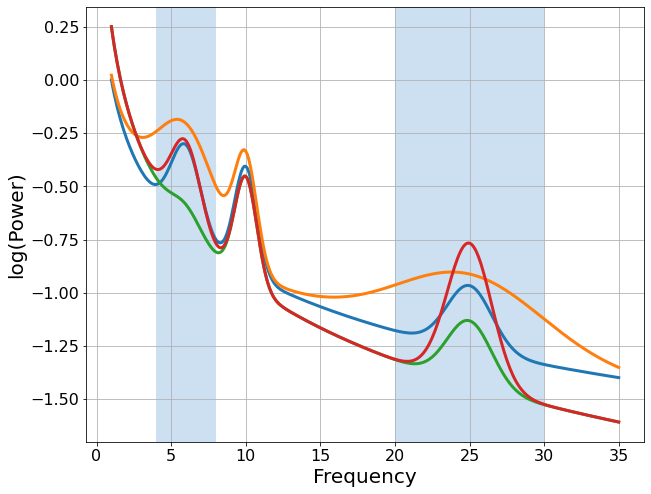

In [25]:
# Plot all the power spectra together
plot_spectra_shading(freqs, spectra_list, [theta_band, beta_band],
                     shade_colors=shade_color, linewidth=3,
                     log_freqs=False, log_powers=True)
if SAVE_FIG: plt.savefig(fp.make_file_path(fp.demo, 'EquivalentRatioSpectra', 'pdf'))

In the plot above, we can see four different power spectra. 

However, each of these power spectra has the exact same measured theta / beta ratio value. 

Thus we can conclude that measuring the same band ratio value for different power spectra should not be taken to imply that they are in any way equivalent.